In [ ]:
# !pip install pandas numpy statsmodels scikit-learn xgboost seaborn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from warnings import simplefilter
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
# https://portal.inmet.gov.br/dadoshistoricos

df = pd.read_csv('/content/dados_A771_D_2018-03-13_2024-09-01.csv',
            sep=';',
            decimal=',',
            on_bad_lines='skip',
            skiprows=11,
            names=['date', 'temperature', None],
            usecols=['date', 'temperature']
            )

auxiliar = df.copy()
auxiliar['date'] = pd.to_datetime(auxiliar['date'])
auxiliar.set_index('date', inplace=True)
auxiliar = auxiliar.asfreq('D') # Setting the frequency to Daily
auxiliar = auxiliar.interpolate(method='linear')
auxiliar.isna().any()

if auxiliar.isna().any().item():
  auxiliar.dropna(inplace=True)

auxiliar.head()

,temperature
date,
2018-03-16,24.2
2018-03-17,22.8
2018-03-18,22.4
2018-03-19,24.1
2018-03-20,23.5


In [ ]:
df['date'] = pd.to_datetime(df['date'])

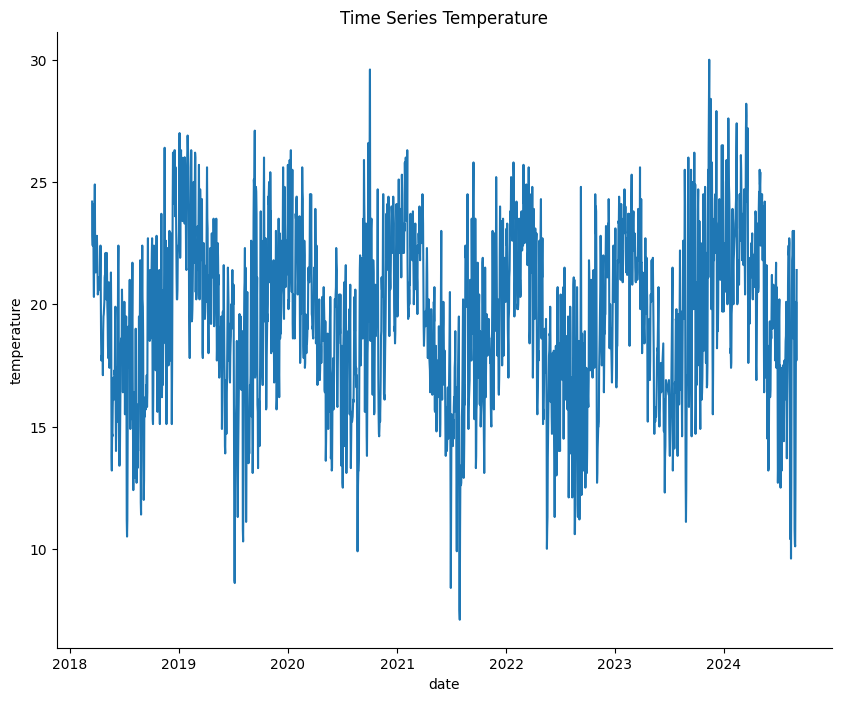

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

g = sns.lineplot(x='date', y='temperature',  data=df, ax=ax)

sns.despine();

g.set(title="Time Series Temperature");

# Tendência (Trend Engineering)

Vamos fazer um plot da média movel da temperatura em busca de algum tipo de tendência na serie temporal.  
Como a serie comtém dados na frequência diaria, vamos utilizar uma janela de valor alto para suavizar qualquer Short-Term ao longo da série.  

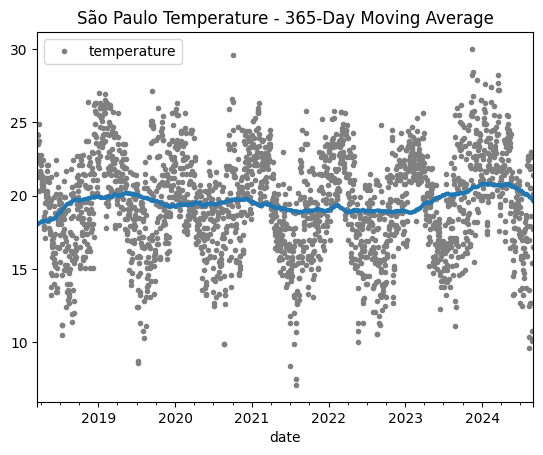

In [ ]:
moving_average = auxiliar.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = auxiliar.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="São Paulo Temperature - 365-Day Moving Average", legend=False,
);

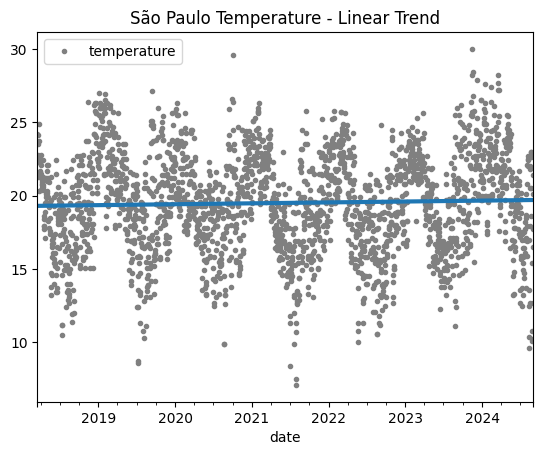

In [ ]:
dp = DeterministicProcess(
    index=auxiliar.index,   # dates from the training data
    constant=True,          # dummy feature for the bias (y_intercept)
    order=1,                # the time dummy (trend)
    drop=True,              # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

y = auxiliar["temperature"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = auxiliar.plot(style=".", color="0.5", title="São Paulo Temperature - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

Observabdo ambas as imagens, vemos que a tendência feita pela média móvel tende a se assemelhar a tendência encontrada pela regressão linear.  
Normalmente valores de temperaturas tem uma tendência com baixa variação ao longo do tempo, o que pode ser visto pela tendência linear.
Se mudarmos a ordem polinomial do processo deterministico (1 - Linear, 2 - Quadrático, ...) obteriamos uma tendência mais agressiva que poderia jogar valores futuros ao extremo.   
Vamos observar algumas pequenas previsões na tendência.

In [ ]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

def previsão_de_tendencia(data, ordem_polinomial, janela_movel_de_previsao=30):
  dp = DeterministicProcess(
    index=data.index,   # dates from the training data
    constant=True,          # dummy feature for the bias (y_intercept)
    order=ordem_polinomial,                # the time dummy (trend)
    drop=True,              # drop terms if necessary to avoid collinearity
  )

  X = dp.in_sample()

  y = data["temperature"]

  model = LinearRegression(fit_intercept=False)
  model.fit(X, y)

  y_pred = pd.Series(model.predict(X), index=X.index)

  X = dp.out_of_sample(steps=janela_movel_de_previsao)

  y_fore = pd.Series(model.predict(X), index=X.index)

  ax = data.plot(title=f"São Paulo Temperature - Polinomial({ordem_polinomial}) Trend Forecast", **plot_params)
  ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
  ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
  _ = ax.legend()

<ipython-input-11-088ac34f2b62>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


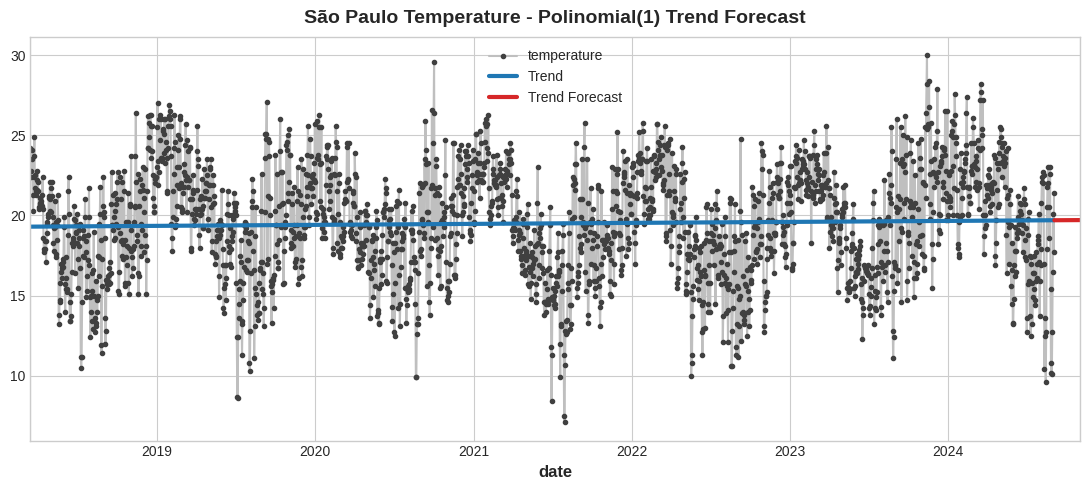

In [ ]:
previsão_de_tendencia(auxiliar, 1, 60)

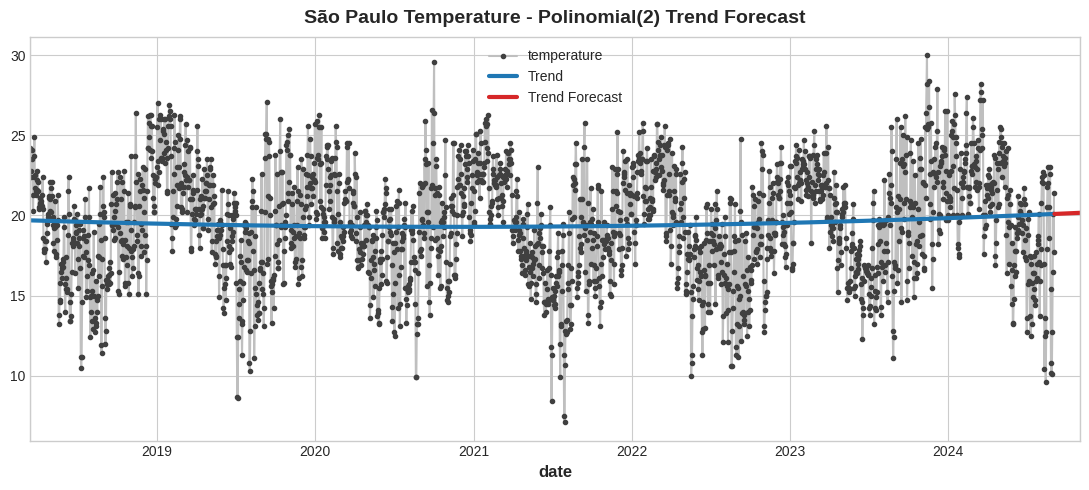

In [ ]:
previsão_de_tendencia(auxiliar, 2, 60)

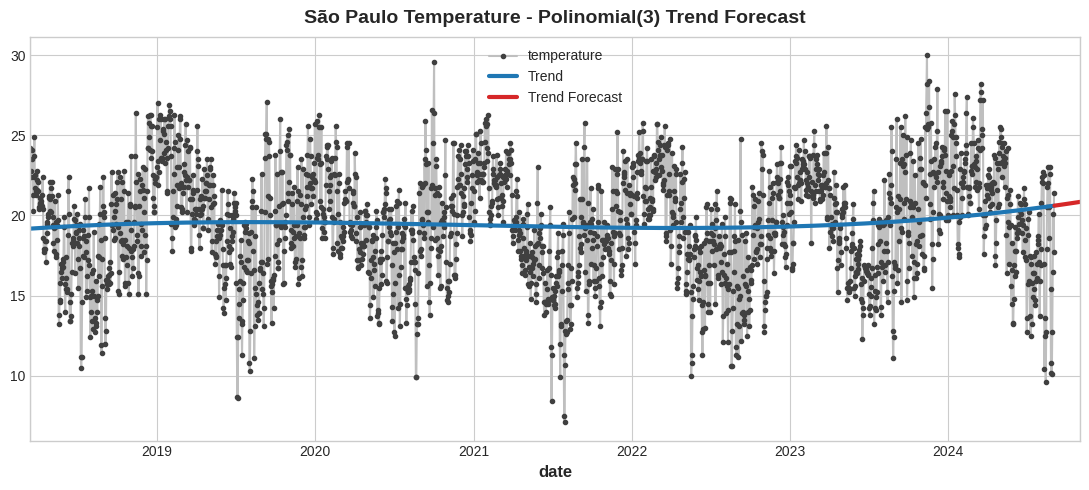

In [ ]:
previsão_de_tendencia(auxiliar, 3, 60)

A tendência linear é o que mais parece se encaixar na série temporal.  
Com uma quantidade de dados maior seria ainda mais perceptível.   

# Sazonalidade (Season)

Uma série temporal apresenta sazonalidade quando há mudanças regulares e periódicas na média. Essas variações geralmente seguem padrões diários, semanais ou anuais, influenciadas por ciclos naturais ou hábitos sociais.  
Como visto no primeiro gráfico deste estudo, é possível observar uma tendência que se repete ao longo dos anos. Enquanto que as observações de curto-prazo não seguem uma tendência específica.  
Para observar isso um pouco mais de perto, vamos utilizar algumas visualizações. O Periodograma e o Seasonal Plot.

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    """
    Gera um gráfico sazonal mostrando padrões recorrentes ao longo de períodos e frequências especificadas.

    Parâmetros:
    ----------
    X : DataFrame
        Conjunto de dados que contém as colunas de períodos e frequências para plotar o gráfico.
    y : str
        Nome da coluna de valores que será plotada no eixo Y.
    period : str
        Nome da coluna no DataFrame que contém os períodos (ex: dias da semana, meses).
    freq : str
        Nome da coluna no DataFrame que contém as frequências associadas ao eixo X (ex: dias do ano, semanas).
    ax : matplotlib.axes.Axes, opcional
        Eixo onde o gráfico será plotado. Se não for fornecido, um novo eixo será criado.

    Retorna:
    -------
    ax : matplotlib.axes.Axes
        O eixo contendo o gráfico sazonal gerado.

    Detalhes:
    --------
    A função cria um gráfico de linhas onde as séries são coloridas de acordo com o período especificado.
    Também adiciona anotações com os nomes dos períodos ao final de cada linha para facilitar a leitura visual.
    """
    # Cria o eixo do gráfico, se não fornecido
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 3))

    # Define uma paleta de cores baseada no número único de períodos
    palette = sns.color_palette("husl", n_colors=X[period].nunique())

    # Plota o gráfico de linhas
    ax = sns.lineplot(
        x=freq, y=y, hue=period, data=X, ax=ax, ci=None,
        palette=palette, legend=False,
    )

    # Define o título do gráfico
    ax.set_title(f"Seasonal Plot ({period}/{freq})")

    # Adiciona anotações ao final de cada linha com o nome do período
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )

    return ax

In [ ]:
def plot_periodogram(ts, detrend='linear', ax=None):
    """
    Gera um periodograma, que exibe a distribuição de variância de uma série temporal em diferentes frequências.

    Parâmetros:
    ----------
    ts : Series
        Série temporal que será analisada.
    detrend : str, opcional
        Tipo de tratamento da tendência a ser aplicado antes do cálculo do periodograma.
        O valor padrão é 'linear'.
    ax : matplotlib.axes.Axes, opcional
        Eixo onde o periodograma será plotado. Se não for fornecido, um novo eixo será criado.

    Retorna:
    -------
    ax : matplotlib.axes.Axes
        O eixo contendo o periodograma gerado.

    Detalhes:
    --------
    A função utiliza o método `periodogram` da biblioteca `scipy.signal` para calcular a densidade espectral
    da série temporal, removendo possíveis tendências. O gráfico resultante usa uma escala logarítmica no eixo X
    e rotula as frequências de forma compreensível (anual, mensal, semanal, etc.).
    """
    from scipy.signal import periodogram

    # Define a frequência de amostragem baseada em um ano de 365 dias
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")

    # Calcula o periodograma
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling="spectrum",
    )

    # Cria o eixo do gráfico, se não fornecido
    if ax is None:
        _, ax = plt.subplots()

    # Plota o espectro de frequências
    ax.step(frequencies, spectrum, color='purple')

    # Define a escala logarítmica no eixo X
    ax.set_xscale("log")

    # Define os pontos específicos no eixo X e seus rótulos
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )

    # Formata os rótulos do eixo Y para notação científica
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    # Define o rótulo e o título do gráfico
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax


<ipython-input-15-2def6dc407c6>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(
<ipython-input-15-2def6dc407c6>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(
<ipython-input-15-2def6dc407c6>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(


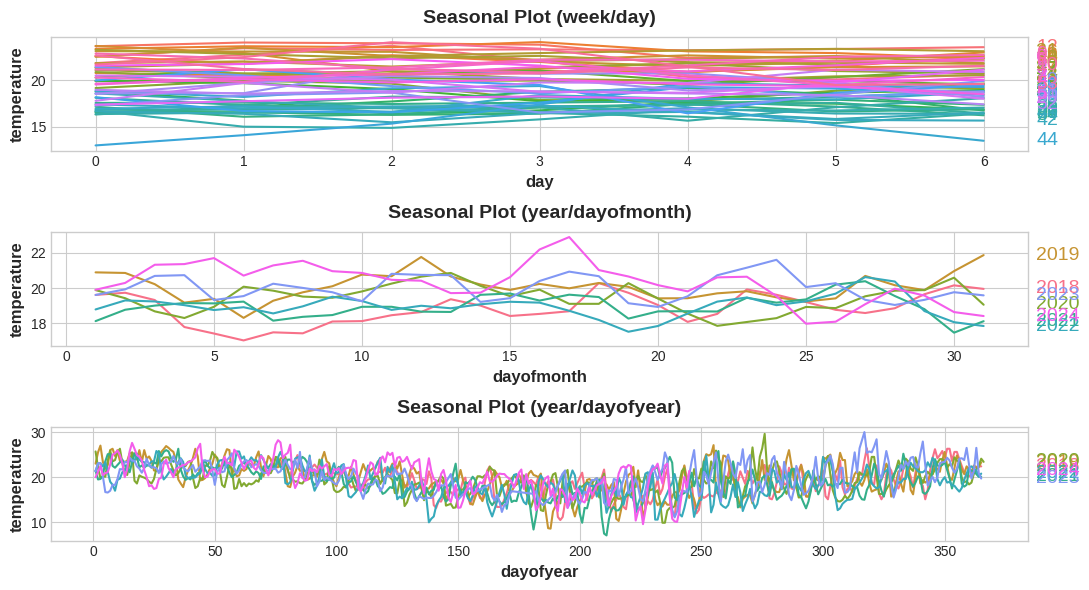

In [ ]:
X = auxiliar.copy()
X = X.to_period()

# Period
X["day"] = X.index.dayofweek
X["week"] = X.index.week

# Freq
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
X["dayofmonth"] = X.index.day

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(11, 6))
seasonal_plot(X, y="temperature", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="temperature", period="year", freq="dayofmonth", ax=ax1)
seasonal_plot(X, y="temperature", period="year", freq="dayofyear", ax=ax2);

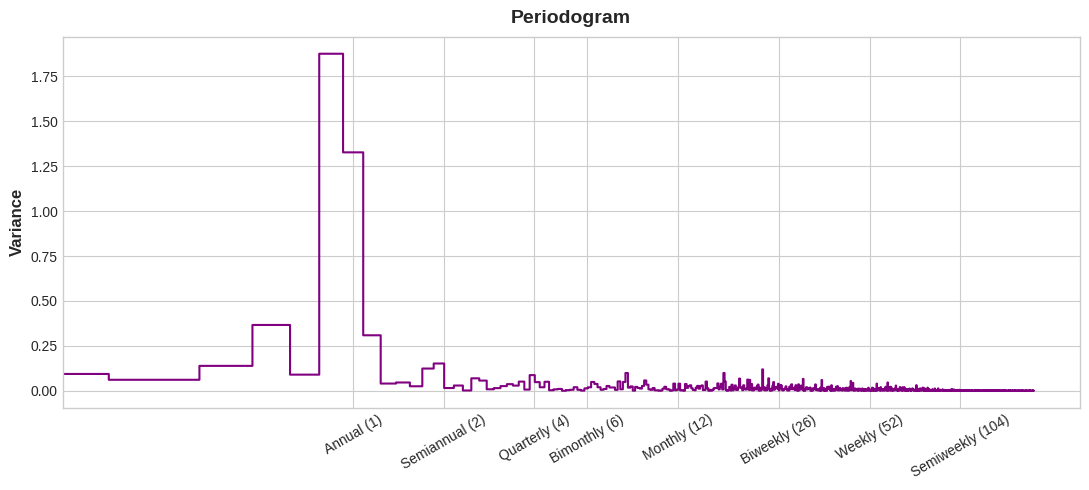

In [ ]:
plot_periodogram(auxiliar.temperature);

### Seasonal Plots:
- Não é possível observar nenhuma sazonalidade de curto prazo dentro do período semanal ou mensal.  
- O período anual parece ser o que contém melhor relação.

### Periodograma:
- Vemos que a frequência anual tem a maior variância.
- Os valores caem logo em seguida.


Não há necessidade de modelar sazonalidades de curto prazo, apenas a sazonalidade anual. Para isso iremos utilizar Séries de Fourier.

In [ ]:

def sazonalidade_com_serie_de_fourier(fourier_order, deterministic_order, forecast_steps):
  # Série de Fourier
  fourier = CalendarFourier(freq='A', order=fourier_order)  # 'A' is annual, 2 pares de seno e cosseno.

  # Processo Deterministico
  dp = DeterministicProcess(
      index=auxiliar.index,        # Time index
      constant=True,               # dummy feature for bias (y-intercept)
      order=deterministic_order,   # trend (order 1 means linear)
      seasonal=False,              # seasonality (indicators)
      additional_terms=[fourier],  # seasonality (fourier)
      drop=True,                   # drop
  )

  X = dp.in_sample()

  y = auxiliar['temperature']

  model = LinearRegression(fit_intercept=False)
  _ = model.fit(X, y)

  y_pred = pd.Series(model.predict(X), index=y.index)
  X_fore = dp.out_of_sample(steps=forecast_steps)
  y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

  ax = y.plot(color='0.25', style='.', title=f"Seasonal Forecast - Fourier({fourier_order}) + Polinomial({deterministic_order})")
  ax = y_pred.plot(ax=ax, label="Seasonal")
  ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
  _ = ax.legend()

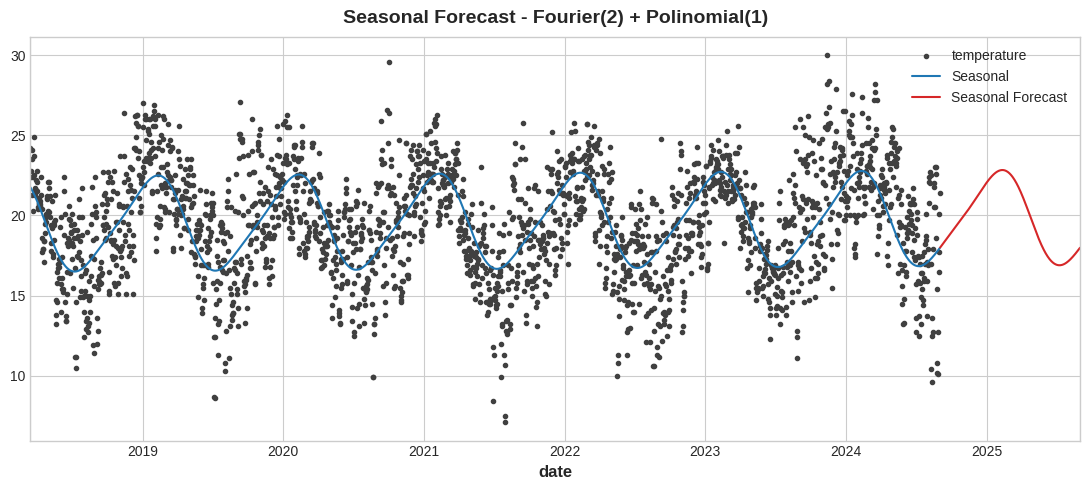

In [ ]:
sazonalidade_com_serie_de_fourier(2, 1, 364)

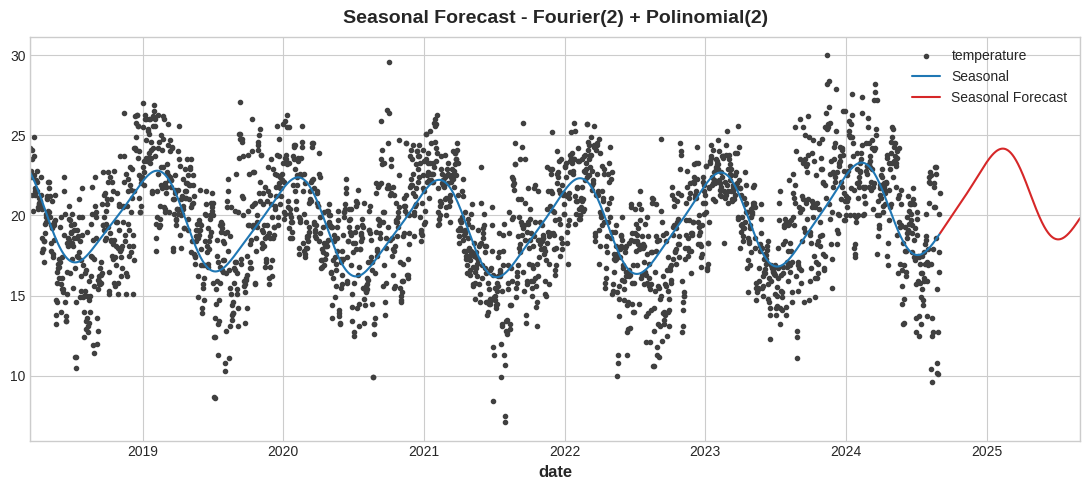

In [ ]:
sazonalidade_com_serie_de_fourier(2, 2, 364)

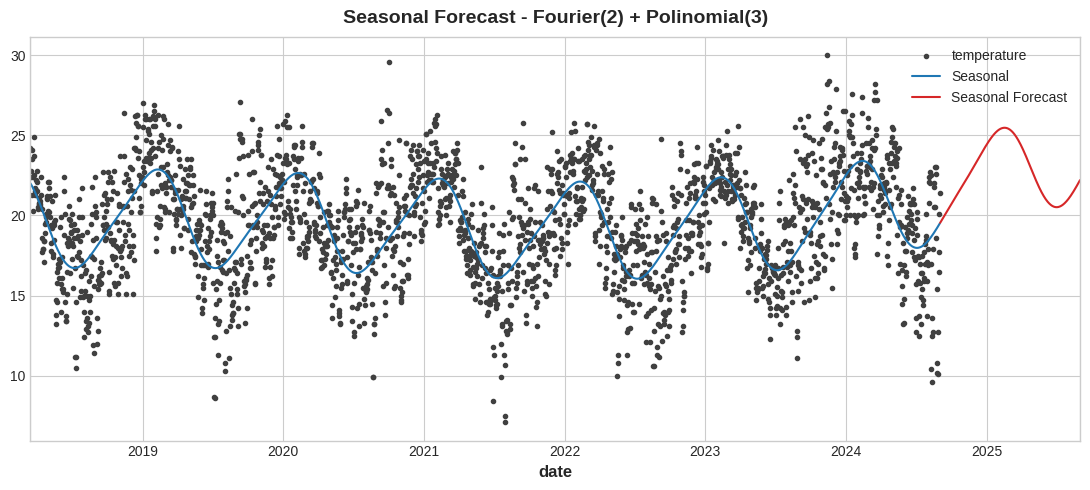

In [ ]:
sazonalidade_com_serie_de_fourier(2, 3, 364)

Podemos observar que a sazonalidade foi bem interpretada. Porém para polinomiais mais altos vemos que o modelo agressiva muito na tendência (a mesma observada anteriormente).  

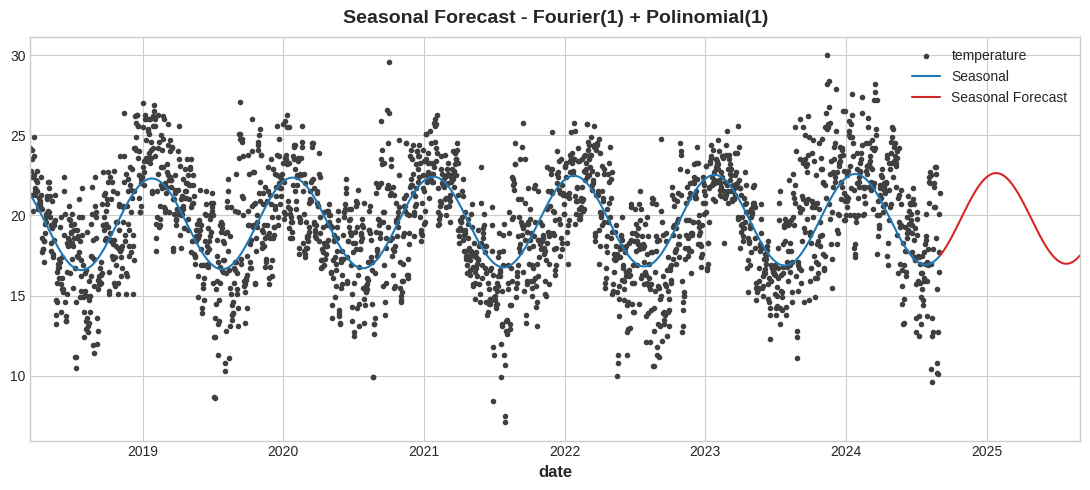

In [ ]:
sazonalidade_com_serie_de_fourier(1, 1, 364)

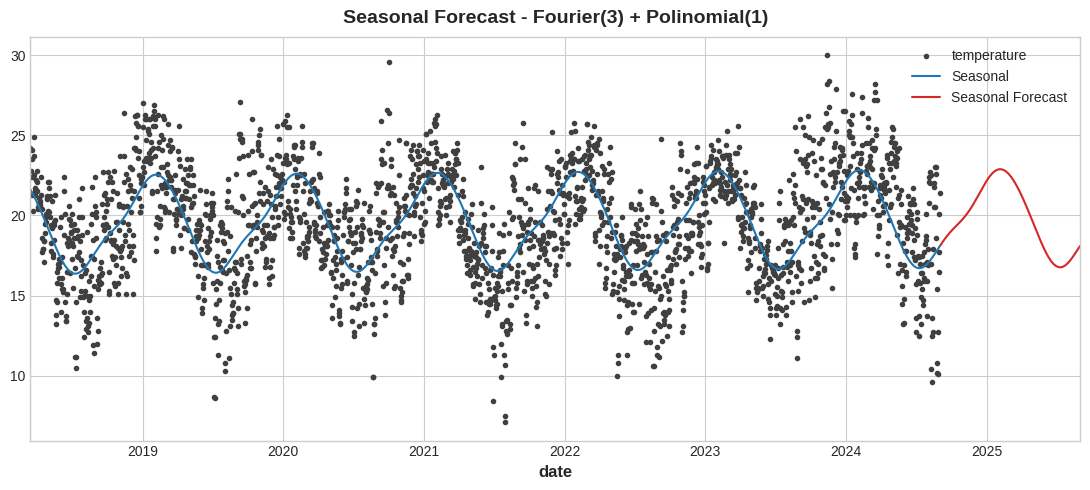

In [ ]:
sazonalidade_com_serie_de_fourier(3, 1, 364)

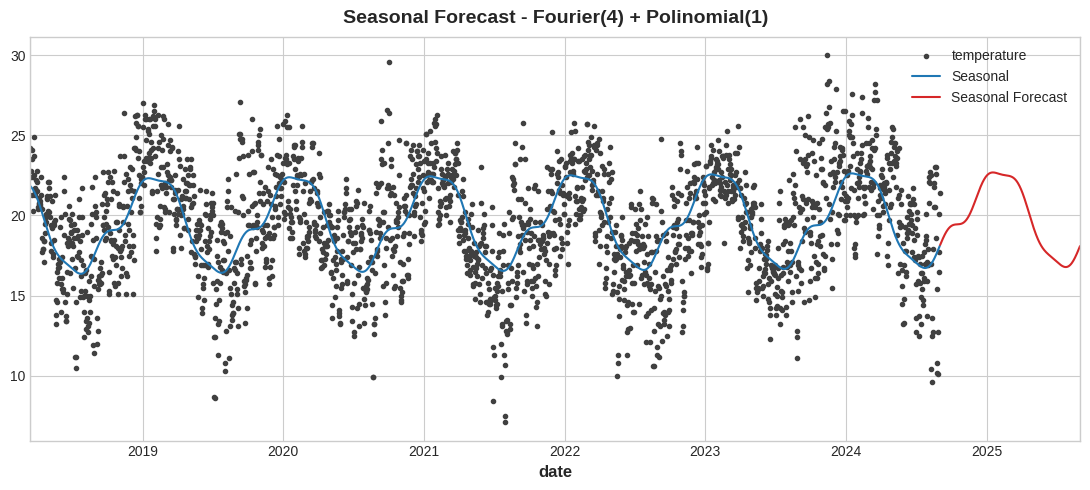

In [ ]:
sazonalidade_com_serie_de_fourier(4, 1, 364)

Podemos ver que aumentar o numero de pares sen e cos suja a modelagem da série.  
O ideal é mantermos nossa escolha entre 1 e 2.

# Ciclos (Cycles)

Ciclos são padrões recorrentes de aumento e diminuição em séries temporais, onde os valores presentes dependem de valores anteriores, mas não necessariamente do intervalo de tempo. Esse comportamento é comum em sistemas que se influenciam ou cujas reações duram ao longo do tempo, como economias, epidemias e fenômenos naturais.

Para verificar a auto dependência da série temporal, vamos utilizar um tipo de váriavel chamada Lags. Os lags em uma série temporal são uma movimentação de N valores da própria série, também chamada de "shift foward".

Utilizar as autocorrelações parciais nos diz o quanto uma Lag Feature adiciona na explicabilidade da série descontando os efeitos da Lag anterior. Podemos utilizar essa informação para não adicionarmos mais informação que o necessário e não causar problemas de multicolinearidades.

In [ ]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    """
    Gera um gráfico de dispersão para visualizar a relação entre uma série temporal e sua versão deslocada.

    Parâmetros:
    -----------
    x : pandas.Series
        Série temporal de entrada.
    y : pandas.Series, opcional
        Série temporal alvo para comparação com a versão deslocada de 'x'. Se não for fornecida, será usada a própria 'x'.
    lag : int, opcional
        Quantidade de deslocamento (lag) aplicado à série 'x'. O padrão é 1.
    standardize : bool, opcional
        Se True, as séries 'x' e 'y' serão padronizadas (subtraindo a média e dividindo pelo desvio padrão). O padrão é False.
    ax : matplotlib.axes.Axes, opcional
        O eixo onde o gráfico será plotado. Se None, um novo eixo será criado.
    **kwargs : dict
        Argumentos adicionais a serem passados para a função sns.regplot().

    Retorna:
    --------
    ax : matplotlib.axes.Axes
        O eixo contendo o gráfico gerado.

    Detalhes:
    ---------
    A função cria um gráfico de dispersão que compara uma série temporal com sua versão deslocada, com a
    possibilidade de aplicar uma linha de ajuste utilizando uma regressão de mínimos quadrados ou LOWESS.
    Também exibe o valor da correlação entre as séries no gráfico.
    """
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    """
    Gera múltiplos gráficos de lag (deslocamento) para visualizar a relação entre uma série temporal e sua versão deslocada.

    Parâmetros:
    -----------
    x : pandas.Series
        Série temporal de entrada.
    y : pandas.Series, opcional
        Série temporal alvo para comparação com os lags de 'x'. Se não for fornecida, será usada a própria 'x'.
    lags : int, opcional
        Número de lags a serem plotados. O padrão é 6.
    nrows : int, opcional
        Número de linhas no layout dos subplots. O padrão é 1.
    lagplot_kwargs : dict, opcional
        Argumentos adicionais a serem passados para a função lagplot().
    **kwargs : dict
        Argumentos adicionais para configuração dos subplots (como figsize, nrows, ncols, etc.).

    Retorna:
    --------
    fig : matplotlib.figure.Figure
        Figura contendo todos os subplots gerados.

    Detalhes:
    ---------
    A função cria uma grade de subplots para visualizar múltiplos gráficos de lag de uma série temporal, permitindo
    a análise de padrões temporais em diferentes deslocamentos (lags). Cada gráfico representa a relação entre
    a série e sua versão deslocada em diferentes períodos.
    """
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


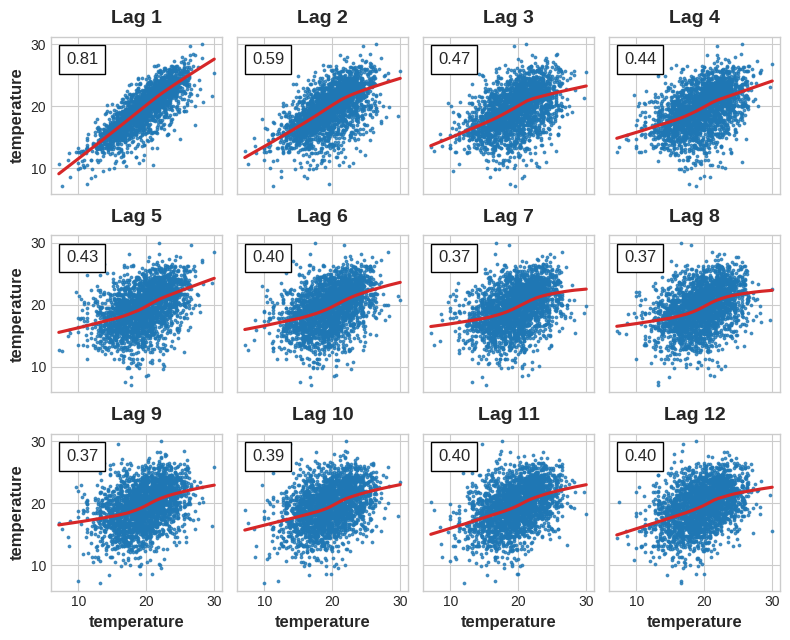

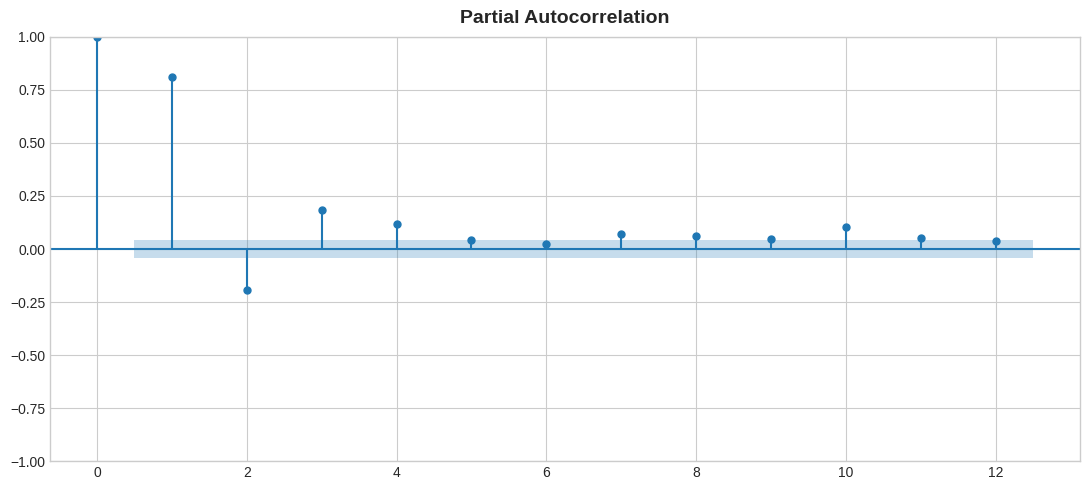

In [ ]:
_ = plot_lags(auxiliar.temperature, lags=12, nrows=3)
_ = plot_pacf(auxiliar.temperature, lags=12)

Primeiro vemos que nem todas as Lags tem um relacionamento linear com a temperatura. Isso pode ser resolvido via Feature Engineering, transformando elas de modo que o resultado seja um relacionamento linear, ou utilizando um algortimo apropriado que possa aprender as relações não lineares.

Segundo vemos que as Lags 1, 2, 3, 4 estão fora no intervalo de "Não correlação" - intervalo azul.  
A lag 5 ao que parece está no limite do intervalo de não correlação.  
As demais como 7 e 10 podem ser falsos positivos.

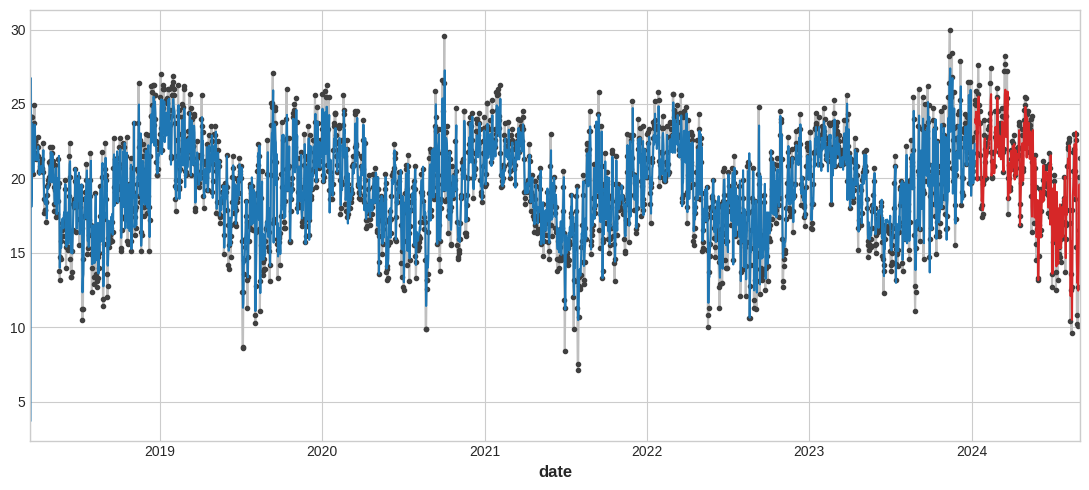

In [ ]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(auxiliar.temperature, lags=4)
X = X.fillna(0.0)

# Create target series and data splits
y = auxiliar.temperature.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

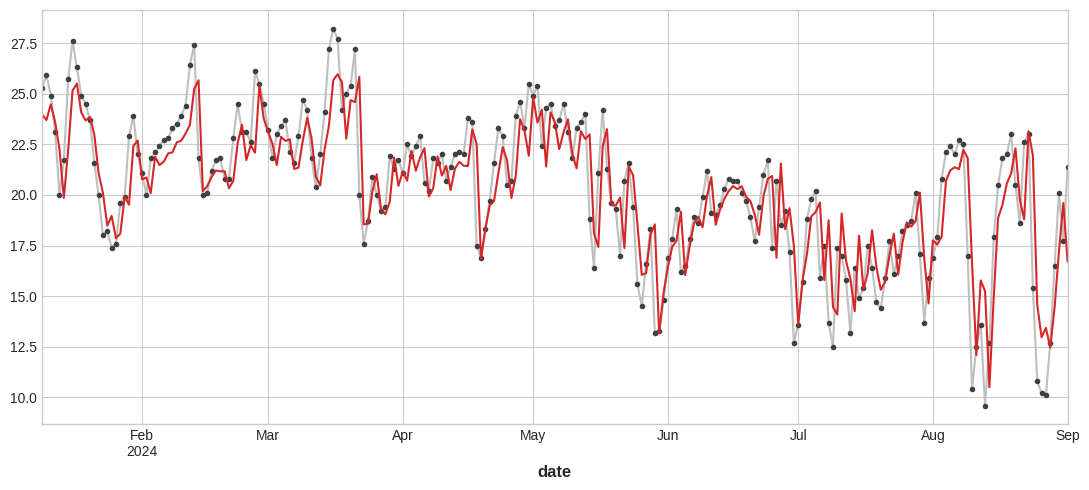

In [ ]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

É possível ver que o modelo precisa de um "tempo" para reagir a alguns tipos de mudanças. Isso é comum quando usamos somente LagFeatures para modelagem.

# Modelagem Hibrida

Até o momento usamos um modelo linear para capturar os componentes. Mas podemos separar usando mais de um algoritmo para componentes diferentes.  
Para isso vamos usar um algoritmo para a série original e suas componentes, e um segundo algoritmo para a série residual.



In [ ]:
# Model 1 (trend)
from sklearn.linear_model import Ridge

# Model 2
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error

auxiliar = df.copy()
auxiliar['date'] = pd.to_datetime(auxiliar['date'])
auxiliar.set_index('date', inplace=True)
auxiliar = auxiliar.asfreq('D') # Setting the frequency to Daily
auxiliar = auxiliar.interpolate(method='linear')
if auxiliar.isna().any().item():
  auxiliar.dropna(inplace=True)


auxiliar['Lag1'] = auxiliar['temperature'].shift(1)
auxiliar['Lag2'] = auxiliar['temperature'].shift(2)
auxiliar['Lag3'] = auxiliar['temperature'].shift(3)
auxiliar['Lag4'] = auxiliar['temperature'].shift(4)
auxiliar['Lag5'] = auxiliar['temperature'].shift(5)
auxiliar['Lag6'] = auxiliar['temperature'].shift(6)
auxiliar['RollingMean'] = auxiliar['temperature'].rolling(window=7, closed='left').mean()
auxiliar['RollingMean30'] = auxiliar['temperature'].rolling(window=30, closed='left').mean()


In [ ]:
auxiliar.iloc[-8:-1].temperature.mean()


14.014285714285716

In [ ]:
auxiliar.iloc[-8:]


,temperature,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,RollingMean,RollingMean30
date,,,,,,,,,
2024-08-25,10.8,15.4,23.0,22.6,18.6,20.5,23.0,20.728571,18.413333
2024-08-26,10.2,10.8,15.4,23.0,22.6,18.6,20.5,19.128571,18.156667
2024-08-27,10.1,10.2,10.8,15.4,23.0,22.6,18.6,17.300000,17.873333
2024-08-28,12.7,10.1,10.2,10.8,15.4,23.0,22.6,15.814286,17.540000
2024-08-29,16.5,12.7,10.1,10.2,10.8,15.4,23.0,14.971429,17.393333
2024-08-30,20.1,16.5,12.7,10.1,10.2,10.8,15.4,14.100000,17.486667
2024-08-31,17.7,20.1,16.5,12.7,10.1,10.2,10.8,13.685714,17.626667
2024-09-01,21.4,17.7,20.1,16.5,12.7,10.1,10.2,14.014286,17.653333


In [ ]:

train_size = int(len(auxiliar) * 0.9)
df_train = auxiliar.iloc[:train_size]
df_test = auxiliar.iloc[train_size:]

def modelo(hidden_layer, activation, solver, alpha):
  fourier_annual = CalendarFourier(freq='A', order=2)  # Ciclos anuais

  # Deterministic process: combine a time trend (optional), Fourier features, and other seasonal terms
  dp = DeterministicProcess(
      index=df_train.index,        # Time index
      constant=True,               # dummy feature for bias (y-intercept)
      order=1,                     # trend (order 1 means linear)
      seasonal=False,               # weekly seasonality (indicators)
      additional_terms=[fourier_annual],  # annual seasonality (fourier)
      drop=True,                   # drop
  )

  # Generate time-related features with cycles included
  X_deterministic = dp.in_sample()

  # Fit the same LinearRegression as before
  model_lr = Ridge(fit_intercept=False)
  model_lr.fit(X_deterministic, df_train['temperature'])

  # Get predictions for trend + seasonality + cycle
  y_pred_deterministic_with_cycle = model_lr.predict(X_deterministic)

  # Remove missing values
  X_features = df_train[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'RollingMean', 'RollingMean30']].fillna(0)
  y_residuals = (df_train['temperature'] - y_pred_deterministic_with_cycle).loc[X_features.index]

  # Fit XGBoost to residuals (which now include cycle-related information)
  model_xgb = MLPRegressor(
        hidden_layer_sizes=hidden_layer,
        activation=activation,
        solver=solver,
        alpha=alpha,
        max_iter=1000,
        random_state=1
    ) # XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=3)
  model_xgb.fit(X_features, y_residuals)

  # Predict residuals
  y_pred_residuals = model_xgb.predict(X_features)

  # Combine predictions (linear model with cycles + residuals)
  final_pred_with_cycles = y_pred_deterministic_with_cycle + y_pred_residuals

  X_deterministic_test = dp.out_of_sample(steps=len(df_test))

  y_pred_deterministic_with_cycle_test = model_lr.predict(X_deterministic_test)

  # Remove missing values
  X_features_test = df_test[['Lag1', 'Lag2', 'Lag3', 'Lag4']].fillna(0)
  y_residuals_test = (df_test['temperature'] - y_pred_deterministic_with_cycle_test).loc[X_features_test.index]

  # Predict residuals
  y_pred_residuals_test = model_xgb.predict(X_features_test)

  # Combine predictions (linear model with cycles + residuals)
  final_pred_with_cycles_test = y_pred_deterministic_with_cycle_test + y_pred_residuals_test

  # 5. Avaliação do modelo no teste
  mae = mean_absolute_error(df_test['temperature'], final_pred_with_cycles_test)
  rmse = np.sqrt(mean_squared_error(df_test['temperature'], final_pred_with_cycles_test))

  return mae, rmse

In [ ]:
# Função de otimização usando GridSearchCV
def optimize_mlp(df_train, df_test):
    # Definir o espaço de parâmetros para otimização
    param_grid = {
        'hidden_layer_sizes': [(5,), (10,), (15,), (5, 5), (10, 10)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [1e-5, 1e-4, 1e-3],
    }

    results = []  # Lista para armazenar os resultados

    for hidden_layer in param_grid['hidden_layer_sizes']:
        for activation in param_grid['activation']:
            for solver in param_grid['solver']:
                for alpha in param_grid['alpha']:
                    mae, rmse = modelo(hidden_layer, activation, solver, alpha)
                    results.append({
                        'hidden_layer': hidden_layer,
                        'activation': activation,
                        'solver': solver,
                        'alpha': alpha,
                        'MAE': mae,
                        'RMSE': rmse
                    })
    return results


# Chame a função de otimização
results = optimize_mlp(df_train, df_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

In [ ]:
pd.DataFrame(results).sort_values('MAE').head()

,hidden_layer,activation,solver,alpha,MAE,RMSE
26,"(15,)",relu,adam,0.00100,1.922452,2.374951
25,"(15,)",relu,adam,0.00010,1.932515,2.375975
51,"(10, 10)",relu,lbfgs,0.00001,1.970304,2.437715
28,"(15,)",relu,lbfgs,0.00010,1.994522,2.433110
39,"(5, 5)",relu,lbfgs,0.00001,1.999731,2.438680


In [ ]:
def modelo(hidden_layer, activation, solver, alpha):
  fourier_annual = CalendarFourier(freq='A', order=2)  # Ciclos anuais

  # Deterministic process: combine a time trend (optional), Fourier features, and other seasonal terms
  dp = DeterministicProcess(
      index=df_train.index,        # Time index
      constant=True,               # dummy feature for bias (y-intercept)
      order=2,                     # trend (order 1 means linear)
      seasonal=False,               # weekly seasonality (indicators)
      additional_terms=[fourier_annual],  # annual seasonality (fourier)
      drop=True,                   # drop
  )

  # Generate time-related features with cycles included
  X_deterministic = dp.in_sample()

  # Fit the same LinearRegression as before
  model_lr = Ridge(fit_intercept=False)
  model_lr.fit(X_deterministic, df_train['temperature'])

  # Get predictions for trend + seasonality + cycle
  y_pred_deterministic_with_cycle = model_lr.predict(X_deterministic)

  # Remove missing values
  X_features = df_train[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'RollingMean', 'RollingMean30']].fillna(0)
  y_residuals = (df_train['temperature'] - y_pred_deterministic_with_cycle).loc[X_features.index]

  # Fit XGBoost to residuals (which now include cycle-related information)
  model_xgb = MLPRegressor(
        hidden_layer_sizes=hidden_layer,
        activation=activation,
        solver=solver,
        alpha=alpha,
        max_iter=1000,
        random_state=1
    ) # XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=3)
  model_xgb.fit(X_features, y_residuals)

  # Predict residuals
  y_pred_residuals = model_xgb.predict(X_features)

  # Combine predictions (linear model with cycles + residuals)
  final_pred_with_cycles = y_pred_deterministic_with_cycle + y_pred_residuals

  X_deterministic_test = dp.out_of_sample(steps=len(df_test))

  y_pred_deterministic_with_cycle_test = model_lr.predict(X_deterministic_test)

  # Remove missing values
  X_features_test = df_test[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'RollingMean', 'RollingMean30']].fillna(0)
  y_residuals_test = (df_test['temperature'] - y_pred_deterministic_with_cycle_test).loc[X_features_test.index]

  # Predict residuals
  y_pred_residuals_test = model_xgb.predict(X_features_test)

  # Combine predictions (linear model with cycles + residuals)
  final_pred_with_cycles_test = y_pred_deterministic_with_cycle_test + y_pred_residuals_test

  # 5. Avaliação do modelo no teste
  mae = mean_absolute_error(df_train['temperature'], final_pred_with_cycles)
  rmse = np.sqrt(mean_squared_error(df_train['temperature'], final_pred_with_cycles))

  print(f"MAE train: {mae}")
  print(f"RMSE train: {rmse}")

  mae = mean_absolute_error(df_test['temperature'], final_pred_with_cycles_test)
  rmse = np.sqrt(mean_squared_error(df_test['temperature'], final_pred_with_cycles_test))

  print(f"MAE: {mae}")
  print(f"RMSE: {rmse}")

  plt.plot(df_test.index, df_test['temperature'], label="Actual")
  plt.plot(df_test.index, final_pred_with_cycles_test, label="Forecast with Cycles")
  plt.legend()
  plt.show()

In [ ]:
# (15,)	relu	adam	0.00100
modelo(hidden_layer=(15), activation='relu', solver='adam', alpha=0.0010)

(1.922451628979397, 2.374951095559256)

MAE train: 1.5190893255388425
RMSE train: 1.9836830943226655
MAE: 1.7465653892632451
RMSE: 2.194406359769567


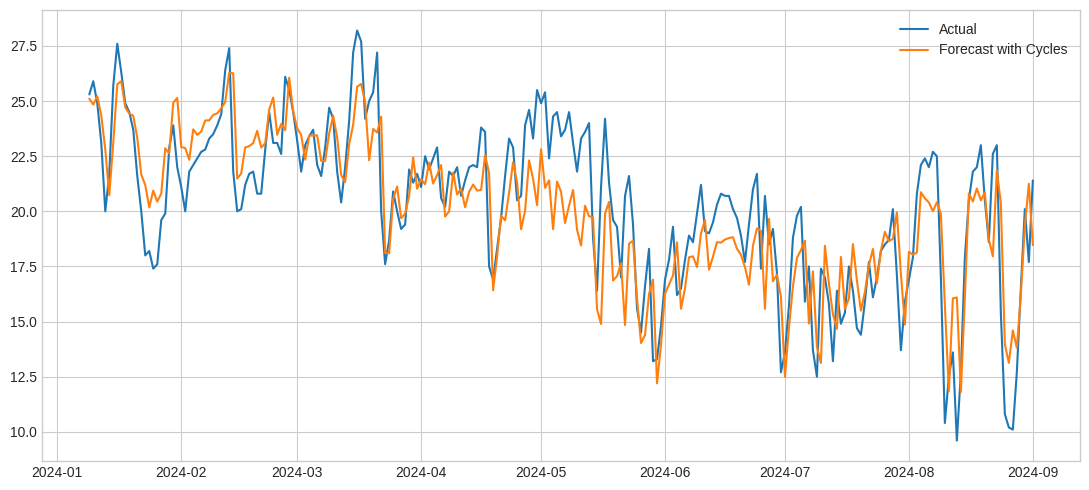

In [ ]:
hidden_layer = (15,)   # Definição da estrutura da rede neural (1 camada oculta com 5 neurônios)
activation = 'relu'   # Função de ativação usada na rede neural
solver = 'adam'      # Otimizador para ajuste dos pesos da rede neural
alpha = 0.0010       # Parâmetro de regularização para a rede neural

# Definindo ciclos anuais com a função de Fourier
fourier_annual = CalendarFourier(freq='A', order=2)  # Ciclos anuais utilizando Fourier de ordem 2

# Processo determinístico: combina uma tendência temporal (opcional), componentes de Fourier e outros termos sazonais
dp = DeterministicProcess(
    index=df_train.index,          # Índice de tempo (datas do conjunto de treino)
    constant=True,                 # Dummy feature para o termo de bias (intercepto)
    order=2,                       # Ordem 1 indica uma tendência linear
    seasonal=False,                # Sazonalidade semanal desativada
    additional_terms=[fourier_annual],  # Sazonalidade anual (Fourier)
    drop=True,                     # Remove colunas redundantes
)

# Gera características relacionadas ao tempo, incluindo ciclos
X_deterministic = dp.in_sample()

# Ajusta um modelo de regressão linear (Ridge) nos dados de treino
model_lr = Ridge(fit_intercept=False)  # Regressão linear sem intercepto
model_lr.fit(X_deterministic, df_train['temperature'])  # Treina o modelo com os dados sazonais

# Obtém previsões do modelo linear nos dados de treino
linear_prediction = model_lr.predict(X_deterministic)

# Seleção de características adicionais (lags e médias móveis)
X_features = df_train[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'RollingMean', 'RollingMean30']].fillna(0)

# Calcula os resíduos (diferença entre as previsões do modelo linear e as temperaturas reais)
y_residuals = (df_train['temperature'] - linear_prediction).loc[X_features.index]

# Ajusta o modelo de rede neural (MLPRegressor) aos resíduos
model_xgb = MLPRegressor(
      hidden_layer_sizes=hidden_layer,  # Estrutura da rede neural
      activation=activation,            # Função de ativação
      solver=solver,                    # Otimizador
      alpha=alpha,                      # Regularização
      max_iter=1000,                    # Máximo de iterações
      random_state=1                    # Semente para reprodutibilidade
)

# Treina o modelo com os resíduos e características adicionais
model_xgb.fit(X_features, y_residuals)

# Previsão dos resíduos usando o modelo de rede neural
model_residuals = model_xgb.predict(X_features)

# Combina as previsões do modelo linear com os resíduos previstos
final_pred = linear_prediction + model_residuals

# Prepara novos dados (dados de teste) para previsão
X_deterministic_test = dp.out_of_sample(steps=len(df_test))

# Previsão da relação linear nos dados de teste
linear_prediction = model_lr.predict(X_deterministic_test)

# Remove valores ausentes das características de teste
X_features_test = df_test[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'RollingMean', 'RollingMean30']].fillna(0)

# Previsão dos resíduos no conjunto de teste
y_pred_residuals_test = model_xgb.predict(X_features_test)

# Combina as previsões do modelo linear com os resíduos previstos no teste
final_pred_with_cycles_test = linear_prediction + y_pred_residuals_test

# Avaliação do modelo: cálculo do MAE (Erro Absoluto Médio) e RMSE (Erro Quadrático Médio) no conjunto de treino
mae = mean_absolute_error(df_train['temperature'], final_pred)
rmse = np.sqrt(mean_squared_error(df_train['temperature'], final_pred))
print(f"MAE train: {mae}")
print(f"RMSE train: {rmse}")

# Avaliação do modelo no conjunto de teste
mae = mean_absolute_error(df_test['temperature'], final_pred_with_cycles_test)
rmse = np.sqrt(mean_squared_error(df_test['temperature'], final_pred_with_cycles_test))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Gráfico das previsões comparadas com os valores reais no teste
plt.plot(df_test.index, df_test['temperature'], label="Actual")
plt.plot(df_test.index, final_pred_with_cycles_test, label="Forecast with Cycles")
plt.legend()
plt.show()


# Final

Numa aplicação real, nosso modelo dessa forma pode prever apenas 1 dia a frente, ja que adiante, não teremos dados para preenchere as LagFeatures e as médias móveis.  
Para resolver isso precisamos fazer uma retroalimentação do modelo.  
A cada iteração nosso modelo irá prever e realimentar a base de dados para previsão.

Vamos fazer um pequeno teste em um escopo de 15 dias.

In [ ]:
a, b = auxiliar.iloc[:-15].copy(), auxiliar.iloc[-15:].copy()

In [ ]:
# (15,)	relu	adam	0.00100
hidden_layer = (15,)   # Definição da estrutura da rede neural (1 camada oculta com 5 neurônios)
activation = 'relu'   # Função de ativação usada na rede neural
solver = 'adam'      # Otimizador para ajuste dos pesos da rede neural
alpha = 0.00100       # Parâmetro de regularização para a rede neural

# Definindo ciclos anuais com a função de Fourier
fourier_annual = CalendarFourier(freq='A', order=2)  # Ciclos anuais utilizando Fourier de ordem 2

# Processo determinístico: combina uma tendência temporal (opcional), componentes de Fourier e outros termos sazonais
dp = DeterministicProcess(
    index=a.index,          # Índice de tempo (datas do conjunto de treino)
    constant=True,                 # Dummy feature para o termo de bias (intercepto)
    order=2,                       # Ordem 1 indica uma tendência linear
    seasonal=False,                # Sazonalidade semanal desativada
    additional_terms=[fourier_annual],  # Sazonalidade anual (Fourier)
    drop=True,                     # Remove colunas redundantes
)

# Gera características relacionadas ao tempo, incluindo ciclos
X_deterministic = dp.in_sample()

# Ajusta um modelo de regressão linear (Ridge) nos dados de treino
model_lr = Ridge(fit_intercept=False)  # Regressão linear sem intercepto
model_lr.fit(X_deterministic, a['temperature'])  # Treina o modelo com os dados sazonais

# Obtém previsões do modelo linear nos dados de treino
linear_prediction = model_lr.predict(X_deterministic)

# Seleção de características adicionais (lags e médias móveis)
X_features = a[['Lag1', 'Lag2', 'Lag3', 'Lag4']].fillna(0)

# Calcula os resíduos (diferença entre as previsões do modelo linear e as temperaturas reais)
y_residuals = (a['temperature'] - linear_prediction).loc[X_features.index]

# Ajusta o modelo de rede neural (MLPRegressor) aos resíduos
model_xgb = MLPRegressor(
      hidden_layer_sizes=hidden_layer,  # Estrutura da rede neural
      activation=activation,            # Função de ativação
      solver=solver,                    # Otimizador
      alpha=alpha,                      # Regularização
      max_iter=1000,                    # Máximo de iterações
      random_state=1                    # Semente para reprodutibilidade
)

# Treina o modelo com os resíduos e características adicionais
model_xgb.fit(X_features, y_residuals)

# Previsão dos resíduos usando o modelo de rede neural
model_residuals = model_xgb.predict(X_features)

# Combina as previsões do modelo linear com os resíduos previstos
final_pred = linear_prediction + model_residuals


In [ ]:
new = a.copy()

for i in range(1,16):
  new_i_row = new.index[-1] + timedelta(days=1)


  lag1 = new.iloc[-1].temperature
  lag2 = new.iloc[-1].Lag1
  lag3 = new.iloc[-1].Lag2
  lag4 = new.iloc[-1].Lag3
  lag5 = new.iloc[-1].Lag4
  lag6 = new.iloc[-1].Lag5
  rolling = new.iloc[-7:].temperature.mean()
  rolling30 = new.iloc[-30:].temperature.mean()

  # Create a new row in our dataframe
  new.loc[new_i_row, 'Lag1'] = lag1
  new.loc[new_i_row, 'Lag2'] = lag2
  new.loc[new_i_row, 'Lag3'] = lag3
  new.loc[new_i_row, 'Lag4'] = lag4
  new.loc[new_i_row, 'Lag5'] = lag5

  # Prepara novos dados (dados de teste) para previsão
  X_deterministic_test = dp.out_of_sample(steps=i).iloc[-1:]

  # Previsão da relação linear nos dados de teste
  linear_prediction = model_lr.predict(X_deterministic_test)

  # Remove valores ausentes das características de teste
  X_features_test = new.loc[new.index[-1:], ['Lag1', 'Lag2', 'Lag3', 'Lag4']]

  # Previsão dos resíduos no conjunto de teste
  y_pred_residuals_test = model_xgb.predict(X_features_test)

  # Combina as previsões do modelo linear com os resíduos previstos no teste
  final_pred_with_cycles_test = linear_prediction + y_pred_residuals_test
  new.loc[new_i_row, 'temperature'] = final_pred_with_cycles_test

In [ ]:
b

,temperature,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,RollingMean,RollingMean30
date,,,,,,,,,
2024-08-18,22.0,21.8,20.5,17.9,12.7,9.6,13.6,15.514286,17.376667
2024-08-19,23.0,22.0,21.8,20.5,17.9,12.7,9.6,16.871429,17.620000
2024-08-20,20.5,23.0,22.0,21.8,20.5,17.9,12.7,18.214286,17.906667
2024-08-21,18.6,20.5,23.0,22.0,21.8,20.5,17.9,19.771429,18.060000
2024-08-22,22.6,18.6,20.5,23.0,22.0,21.8,20.5,20.614286,18.090000
2024-08-23,23.0,22.6,18.6,20.5,23.0,22.0,21.8,21.285714,18.306667
2024-08-24,15.4,23.0,22.6,18.6,20.5,23.0,22.0,21.642857,18.506667
2024-08-25,10.8,15.4,23.0,22.6,18.6,20.5,23.0,20.728571,18.413333
2024-08-26,10.2,10.8,15.4,23.0,22.6,18.6,20.5,19.128571,18.156667


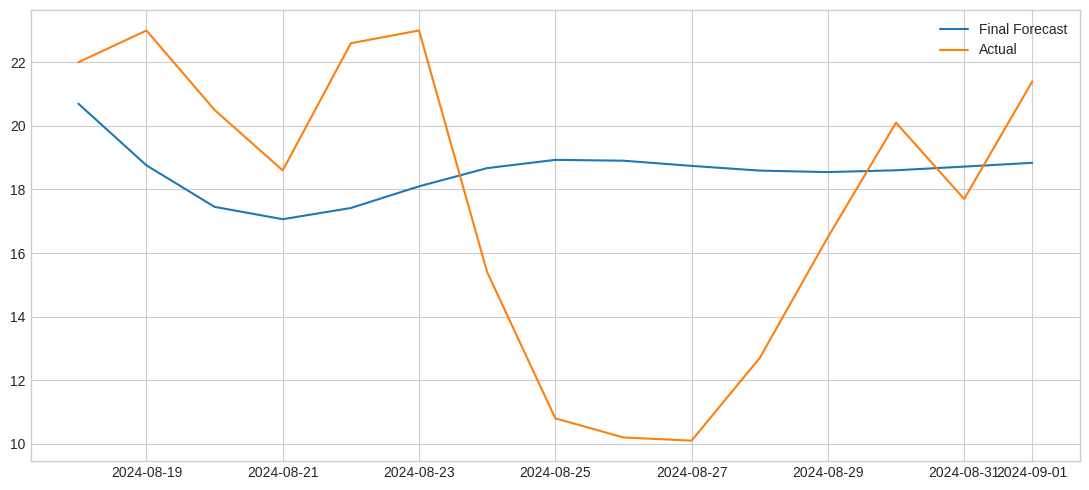

In [ ]:
plt.plot(new.iloc[-15:].index, new.iloc[-15:].temperature, label="Final Forecast")
plt.plot(b.index, b['temperature'], label="Actual")
plt.legend()
plt.show()